In [2]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

# these are new 
import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import shutil                   # file management tools 
import os                       # operating system tools (check files)

import geopandas as gpd # this is the main geopandas 
from shapely.geometry import Point, Polygon # also needed

##########################
# Then this stuff below allows us to make a nice inset


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

### Create a Map and...

Generate trade exposure metrics for which we can project outcomes at the county/cmz level on changes in trade exposure and/or tariff exposure. The key resource that I am exploiting is the [Quarterly Census of Employment and Wages](https://www.bls.gov/cew/datatoc.htm). 

The process will work like this:

- For 2017, read in the data and construct national level employment and wages by NAICS. Issue here is that we need to be consistent about how stuff is masked at different levels of aggregation. So I will start at county level then work up.


- Merge the national level outcomes with the trade data (at the NAICS) level.


- Then we construct county level "weights". So something like a county's share of national employment by NAICS code, multiply this by total exports of that NAICS code, then sum across all NAICS codes, all for a county. This will aportion exports to a county based on their national level employment share. The sum is a summary measure of a county's exports.


- Outstanding issue is that employment is bottom coded, so small isolated establishments within an NAICS code are not reported. This is where the Dorn strategy of "filling in" might be worth using. For now we will ignore it. 

---

#### Step 1: Read in and clean up the BLS, single file dataset.

In [3]:
url = "https://data.bls.gov/cew/data/files/2017/csv/2017_annual_singlefile.zip"
# This will read in the annual, single file. It's big, but has all we want...

r = requests.get(url) 

In [4]:
# convert bytes to zip file  
bls_sf = zf.ZipFile(io.BytesIO(r.content)) 
print('Type of zipfile object:', type(bls_sf))

Type of zipfile object: <class 'zipfile.ZipFile'>


In [5]:
bls_sf.namelist()

['2017.annual.singlefile.csv']

In [6]:
clist = ['area_fips', 'own_code', 'industry_code', 'agglvl_code', 'size_code',
       'year', 'disclosure_code', 'annual_avg_estabs',
       'annual_avg_emplvl', 'total_annual_wages','avg_annual_pay']

# These are the columns we care about and will grab

[https://data.bls.gov/cew/doc/titles/area/area_titles.htm](https://data.bls.gov/cew/doc/titles/area/area_titles.htm)

In [7]:
df = pd.read_csv(bls_sf.open(bls_sf.namelist()[0]), usecols= clist)

C:\Users\mwaugh\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df.head()

,area_fips,own_code,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,avg_annual_pay
0,1000,0,10,50,0,2017,NaN,124881,1936819,89088710816,45997
1,1000,1,10,51,0,2017,NaN,1208,53131,4339038631,81668
2,1000,1,102,52,0,2017,NaN,1208,53131,4339038631,81668
3,1000,1,1021,53,0,2017,NaN,610,11173,716001109,64083
4,1000,1,1022,53,0,2017,NaN,2,12,369309,30354


In [9]:
df.columns

Index(['area_fips', 'own_code', 'industry_code', 'agglvl_code', 'size_code',
       'year', 'disclosure_code', 'annual_avg_estabs', 'annual_avg_emplvl',
       'total_annual_wages', 'avg_annual_pay'],
      dtype='object')

#### Step 2: Create National Aggregates

Now what we want to do is to create a national dataset for which we can merge on the county....

In [10]:
NAICS_county_level = 76 
# This is the code that will select only counties at the 4 digit NAICS level
#https://data.bls.gov/cew/doc/titles/agglevel/agglevel_titles.htm

df_county = df[df.agglvl_code == 76].copy()

df_county = df_county[df_county.own_code == 5]
# Only grab private stuff

df_county = df_county[(df_county.area_fips.str[0:2] != "72") & (df_county.area_fips.str[0:2] != "78")
              & (df_county.area_fips.str[0:2] != "02") & (df_county.area_fips.str[0:2] != "15")]
#Drop puerto rico, alaska, hawaii...

df_county["sup_ind"] = df_county.industry_code.str[1].astype(int)
# sometimes there are super industries floating around we want to drop them.
# not clear if this matters with the conditioning all ready

df_county = df_county[df_county["sup_ind"] > 0]

Then once we have this, we group by NAICS code, then sum across employment. This should give, conditional on the county/naics aggregation, the consistent national level totals.

In [11]:
df_national = df_county.groupby("industry_code").agg({"annual_avg_emplvl": "sum"})

In [12]:
df_national.reset_index(inplace = True)

In [13]:
df_national.shape

(304, 2)

---

#### Step 3. Merge national aggregates with trade data

In [14]:
my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"

end_use = "naics?get=NAICS,CTY_CODE,ALL_VAL_MO,CTY_NAME"

url = "https://api.census.gov/data/timeseries/intltrade/exports/" + end_use + my_key + "&time==from+2017-01" + "&COMM_LVL=NA4"

url = url + "&CTY_CODE=5700"

In [15]:
r = requests.get(url) 

r

<Response [200]>

In [16]:
dftrade = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

dftrade.columns = r.json()[0]

dftrade.time = pd.to_datetime(dftrade.time, format="%Y-%m")
# This is so I can call this correctly...

dftrade.ALL_VAL_MO = dftrade.ALL_VAL_MO.astype(float)

dftrade.head(10)

,NAICS,CTY_CODE,ALL_VAL_MO,CTY_NAME,time,COMM_LVL,CTY_CODE
0,1111,5700,1.931313e+09,CHINA,2017-01-01,NA4,5700
1,1112,5700,1.071322e+06,CHINA,2017-01-01,NA4,5700
2,1113,5700,1.480522e+07,CHINA,2017-01-01,NA4,5700
3,1114,5700,1.512023e+06,CHINA,2017-01-01,NA4,5700
4,1119,5700,1.673608e+08,CHINA,2017-01-01,NA4,5700
5,1121,5700,1.172263e+06,CHINA,2017-01-01,NA4,5700
6,1122,5700,2.740000e+03,CHINA,2017-01-01,NA4,5700
7,1124,5700,3.917830e+05,CHINA,2017-01-01,NA4,5700
8,1125,5700,2.599500e+04,CHINA,2017-01-01,NA4,5700
9,1129,5700,1.046655e+06,CHINA,2017-01-01,NA4,5700


In [17]:
dftrade.set_index("time", inplace = True)

In [18]:
df17naics_trade = dftrade.loc["2017"].groupby("NAICS").agg({"ALL_VAL_MO":"sum"})


Alot going on here, grab 2017, groupby NAICS code, then compute the sum. So for a given NAICS code, this will be summing across all observations, which in this case is across months. Thus this is annual exports, by NAICS codes.

In [19]:
df17naics_trade.head()

,ALL_VAL_MO
NAICS,
1111,1.362627e+10
1112,4.750172e+07
1113,4.519789e+08
1114,1.680611e+07
1119,1.665841e+09


In [20]:
total_trade = df17naics_trade.ALL_VAL_MO.sum()

Then merge it with the national level NAICS. Note the groupby operation above leaves the index as the naics code left is on the industry code. Default here is inner, need to think about if I want to carry around zeros.

In [21]:
df_nation_naics = df_national.merge(df17naics_trade, how = "outer", left_on = "industry_code", right_index = True)


In [22]:
print("number of NAICS codes with trade", df_nation_naics.shape[0])
print("national employment", df_nation_naics.annual_avg_emplvl.sum())
print("Potential China Export Employment",df_nation_naics.annual_avg_emplvl.sum())

number of NAICS codes with trade 307
national employment 107022881.0
Potential China Export Employment 107022881.0


In [23]:
df_nation_naics.head()

,industry_code,annual_avg_emplvl,ALL_VAL_MO
0,1111,37447.0,1.362627e+10
1,1112,78485.0,4.750172e+07
2,1113,180531.0,4.519789e+08
3,1114,121550.0,1.680611e+07
4,1119,47430.0,1.665841e+09


In [24]:
df_nation_naics.rename({"annual_avg_emplvl":"nat_emplvl",
                        "ALL_VAL_MO": "china_exports"}, axis = 1, inplace = True)

In [25]:
df_nation_naics.china_exports.replace(np.nan, 0, inplace = True)

In [26]:
df_nation_naics.head()

,industry_code,nat_emplvl,china_exports
0,1111,37447.0,1.362627e+10
1,1112,78485.0,4.750172e+07
2,1113,180531.0,4.519789e+08
3,1114,121550.0,1.680611e+07
4,1119,47430.0,1.665841e+09


#### Step 4: Clean county level data to line up with national aggregates

What I want to do now is rename and probably drop a bunch of this stuff. Then merge it on the national df on the industry code. A think I need to figure out is to only have the county fips codes

In [27]:
df_county.head(10)

,area_fips,own_code,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,avg_annual_pay,sup_ind
3017,1001,5,1111,76,0,2017,N,1,0,0,0,1
3020,1001,5,1114,76,0,2017,N,1,0,0,0,1
3023,1001,5,1119,76,0,2017,N,2,0,0,0,1
3027,1001,5,1121,76,0,2017,N,2,0,0,0,1
3030,1001,5,1129,76,0,2017,N,1,0,0,0,1
3034,1001,5,1132,76,0,2017,N,2,0,0,0,1
3037,1001,5,1133,76,0,2017,N,2,0,0,0,1
3041,1001,5,1151,76,0,2017,N,2,0,0,0,1
3045,1001,5,1152,76,0,2017,N,1,0,0,0,1
3048,1001,5,1153,76,0,2017,NaN,6,22,1793086,81196,1


Below this is just exploring some issues with this. One thing that jumps out is not all NAICS codes are represented within a County. At somepoint need to explore why

In [28]:
df_county.annual_avg_emplvl.sum()

107022881

In [29]:
df_nation_naics.nat_emplvl.sum()

107022881.0

In [30]:
grp = df_county.groupby("area_fips")

In [31]:
grp.get_group(10003).head()

,area_fips,own_code,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,avg_annual_pay,sup_ind
332500,10003,5,1111,76,0,2017,N,6,0,0,0,1
332511,10003,5,1112,76,0,2017,N,1,0,0,0,1
332514,10003,5,1114,76,0,2017,NaN,11,125,4337571,34677,1
332522,10003,5,1121,76,0,2017,N,1,0,0,0,1
332525,10003,5,1123,76,0,2017,N,1,0,0,0,1


In [185]:
def create_trade_exposure(df):

    new_df = df.merge(df_nation_naics, how = "outer", left_on = "industry_code", right_on = "industry_code")
    # Merge the nation with the county, why, we want to make sure all the naics codes are lined up properly
    
    naics_codes = df_nation_naics.shape[0]
    
    county_share = (new_df.annual_avg_emplvl/new_df.nat_emplvl)*(new_df.china_exports)
    # Then at the NAICS level, take a county's employment relative th national employment. 
    # This is like the weight. Then multiply it by NAICS exports. So this is like if LA has 5 percernt in X,
    # Then 5 percent of X's exports go to LA. 
        
    trd_exp = (1/new_df.annual_avg_emplvl.sum())*county_share.sum()
    # Then sum acrross all the NAICS codes
    #trd_exp = county_share.sum()
    
    foo = {"export_exposure": [trd_exp], "employment": [new_df.annual_avg_emplvl.sum()]}
    
    return pd.DataFrame(foo, index = [new_df.area_fips.iloc[0]])
    

In [186]:
single_location = create_trade_exposure(grp.get_group(10001))

In [187]:
single_location

,export_exposure,employment
10001,1014.35348,20205.0


In [188]:
df_trdx_county = grp.apply(create_trade_exposure)

C:\Users\mwaugh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
C:\Users\mwaugh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [189]:
df_trdx_county = df_trdx_county.droplevel(1)

In [190]:
df_trdx_county.sort_values(by = ["export_exposure"], ascending = False)[100:125]

,export_exposure,employment
area_fips,,
38073,30380.996278,527.0
5017,30333.442083,1250.0
38103,30236.569817,349.0
20027,29973.762615,607.0
17023,29912.086976,627.0
29033,29682.174954,662.0
31095,29425.820194,532.0
31121,29404.563890,693.0
19095,29273.457565,3557.0


In [38]:
df_trdx_county.median()

export_exposure     477.836105
employment         2997.000000
dtype: float64

In [261]:
df_trdx_county["q_trx"] = pd.qcut(df_trdx_county["export_exposure"], 10 ,labels = False, duplicates='drop')

### Step 5: Make the MAP

In [263]:
cwd = os.getcwd()

regions_shape = "C:\\Users\\mwaugh\\github\\data_bootcamp_spring_2019\\mapping\\shapefile\\US\\tl_2017_us_county.shx"

In [264]:
us_map = gpd.read_file(regions_shape)

In [265]:
us_map.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477641638,10701538,+41.9158651,-096.7885168,"POLYGON ((-97.019516 42.004097, -97.019519 42...."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680956787,61588406,+46.2946377,-123.4244583,"POLYGON ((-123.436394 46.238197, -123.447592 4..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016761648,29147345,+34.3592729,-104.3686961,"POLYGON ((-104.567387 33.997566, -104.567717 3..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169252486,22867561,+40.7835474,-096.6886584,"POLYGON ((-96.91059899999999 40.958407, -96.91..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645186,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27366699999999 40.089399, -98.27..."


In [266]:
us_map["area_fips"] = (us_map.STATEFP.astype(str) + us_map.COUNTYFP.astype(str)).astype(int)

In [267]:
us_map = us_map.merge(df_trdx_county, on='area_fips', how = "inner", indicator = True)

In [268]:
us_map.set_index("STATEFP", inplace = True)

In [269]:
drop_list = ["02","15","72"]

us_map.drop(drop_list, inplace = True)

In [270]:
us_map.q_trx.replace(np.nan,0,inplace = True)

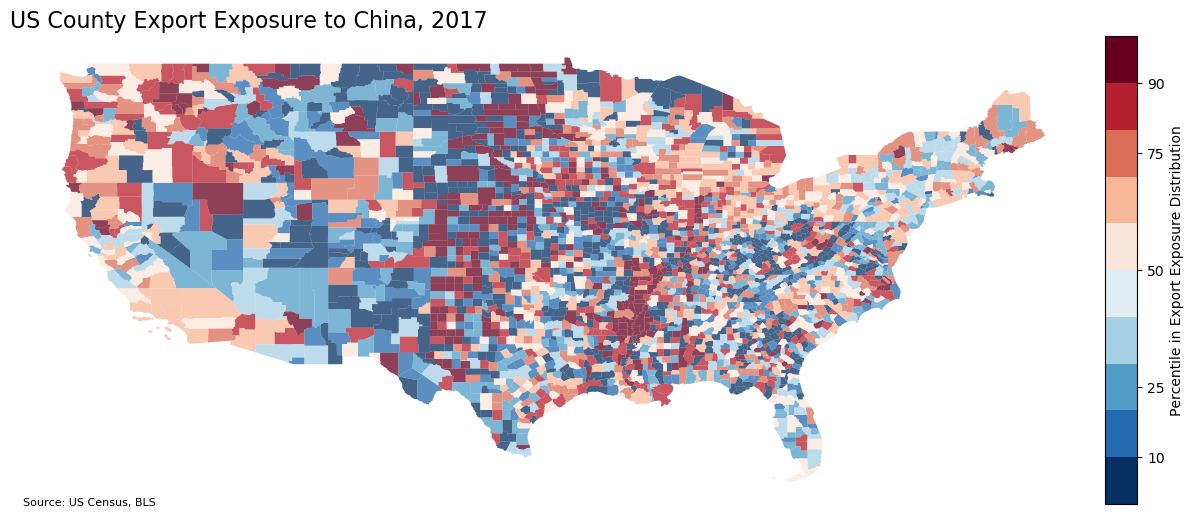

In [334]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1,figsize = (12,8))

plt.tight_layout()
plt.rcParams.update(plt.rcParamsDefault) # This will reset defaluts...

#################################################################################
# This is for the colorbar...

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="3%", pad=0.1)

#################################################################################
## This creates a discrete colorbar scheme...
# https://gist.github.com/jakevdp/91077b0cae40f8f8244a

N = 10

base = plt.cm.get_cmap("RdBu_r")

color_list = base(np.linspace(0, 1, N))

cmap_name = base.name + str(N)

dcmap =  base.from_list(cmap_name, color_list, N)

#################################################################################
# This is the normal mapping...

us_map.plot(column='q_trx', ax = ax,
              # THIS IS NEW, it says color it based on this column
             cmap=dcmap, 
             alpha = 0.75,
             vmin=0, vmax=us_map.q_trx.max())

#################################################################################
# This then alows me to generate and edit the colorbar....
# https://stackoverflow.com/questions/53158096/editing-colorbar-legend-in-geopandas

sm = plt.cm.ScalarMappable(cmap=test)
sm._A = []
cbr = fig.colorbar(sm, cax=cax)

cbr.set_label('Percentile in Export Exposure Distribution')
cbr.set_alpha(0.15)

cbr.set_ticks([0.10, 0.25,0.50,0.75, 0.90])
cbr.set_ticklabels(["10","25","50","75","90"], update_ticks=True)

#################################################################################
# Then some final stuff to clean things up....

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.get_xaxis().set_visible(False)

ax.get_yaxis().set_visible(False)

ax.set_title("US County Export Exposure to China, 2017", fontsize = 16, loc= "left" )

ax.text(-127,23, "Source: US Census, BLS", fontsize = 8)

plt.savefig("us_china_exports_map.pdf", bbox_inches = "tight", dip = 1200)

plt.show()